# CH4 Redes Neuronales

## Importado de Librerías

Importamos lo que utilizaremos en nuestro trabajo.

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV


import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
 
np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

## Lectura CSV y Feature Engineering

Realizamos la lectura de los data set y el feature engineering correspondiente.

In [91]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

In [92]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

In [93]:
# Contamos los valores faltantes
num_missing = df_hotel.isna().sum()
print("El número total de valores faltantes en el DataFrame es:", num_missing.sum())

El número total de valores faltantes en el DataFrame es: 0


In [94]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

In [95]:
cambiar_columna_por_probabilidad_is_canceled('country')
cambiar_columna_por_probabilidad_is_canceled('agent')
cambiar_columna_por_probabilidad_is_canceled('company')

In [96]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

columns = ['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel','deposit_type', 'customer_type', 'assigned_room_type', 'reserved_room_type']

X = pd.get_dummies(X, columns=columns, drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=columns, drop_first=True)

In [97]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

In [98]:
# Obtener las columnas del DataFrame
columnas = df_hotel_test.columns

# Imprimir las columnas
print(columnas)
# Obtener la cantidad de columnas del DataFrame
cantidad_columnas = len(df_hotel_test.columns)

# Imprimir la cantidad de columnas
print(cantidad_columnas)

Index(['lead_time', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'country_prob_is_canceled',
       'agent_prob_is_canceled', 'company_prob_is_canceled',
       'hotel_Resort Hotel', 'arrival_date_year_2016',
       'arrival_date_year_2017', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_May', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Complementary',
       'market_seg

## Modelo con K-Fold Cross Validation


Obtenemos a semilla

In [99]:
semilla = 42
np.random.seed(semilla)
tf.random.set_seed(semilla)

Dividimos nuestro set de datos.

In [100]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

Creamos la funcion que calculará el f1 score.

In [101]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Y con esta funcion haremos la creación de modelos.

In [102]:
def create_model(optimizer='adam', activation='relu', neurons=64, neurons_2=32, neurons_3=32):
    modelo = keras.Sequential([
        keras.layers.Dense(neurons, input_shape=(68,), activation=activation, kernel_initializer='uniform'),
        keras.layers.Dense(neurons_2, activation=activation),
        keras.layers.Dense(neurons_3, activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    modelo.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[get_f1]
    )
    modelo.summary()
    return modelo

Seleccionamos los hiperparametros a optimizar, creamos el modelos y hacemos random search.

In [103]:
param_dist = {
    'optimizer': ['adam', 'nadam'],
    'activation': ['relu', 'sigmoid'],
    'neurons': [68],
    'neurons_2': np.linspace(16, 64, 8),
    'neurons_3': [16, 24, 32]
}

modelo_cv = KerasClassifier(build_fn=create_model)

k = 10
kf = KFold(n_splits=k)

random_search = RandomizedSearchCV(
    estimator=modelo_cv,
    param_distributions=param_dist,
    n_iter=10,
    cv=kf,
    random_state=semilla,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 68)                4692      
                                                                 
 dense_29 (Dense)            (None, 50)                3450      
                                                                 
 dense_30 (Dense)            (None, 24)                1224      
                                                                 
 dense_31 (Dense)            (None, 1)                 25        
                                                                 
Total params: 9,391
Trainable params: 9,391
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


1538/1538 [==============================] - 4s 2ms/step - loss: 0.4959 - get_f1: 0.7392


Aplicamos el regularizador Early Stop para el entrenamiento de epochs de nuestro modelo.

In [104]:
early_stopping = EarlyStopping(patience=12, restore_best_weights=True)
history = best_model.fit(x_train, y_train, epochs=100, batch_size=15, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 68)                4692      
                                                                 
 dense_33 (Dense)            (None, 50)                3450      
                                                                 
 dense_34 (Dense)            (None, 24)                1224      
                                                                 
 dense_35 (Dense)            (None, 1)                 25        
                                                                 
Total params: 9,391
Trainable params: 9,391
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3280/3280 [==============================] - 10s 3ms/step - loss: 0.4803 - get_f1: 0.7403 - val_loss: 0.4575 - val_get_f1: 0.7857
Epoch 2/100
3280/3280 [===================

Primero asignamos una semilla para los valores random de tensorflow, cosa de que las predicciones de la red sean consistentes 

## Métricas

Métricas del conjunto de train

In [112]:
y_pred = best_model.predict(x_train)

f1 = f1_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de train:", f1)
print("Accuracy en el conjunto de train:", accuracy)
print("Precision en el conjunto de train:", precision)

1538/1538 [==============================] - 3s 2ms/step
Mejores hiperparámetros encontrados: {'optimizer': 'adam', 'neurons_3': 24, 'neurons_2': 50.285714285714285, 'neurons': 68, 'activation': 'sigmoid'}
F1_score en el conjunto de train: 0.873295053893422
Accuracy en el conjunto de train: 0.8721540087819157
Precision en el conjunto de train: 0.8692844537141023


Métricas del conjunto de prueba

In [113]:
y_pred = best_model.predict(x_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)

385/385 [==============================] - 1s 2ms/step
Mejores hiperparámetros encontrados: {'optimizer': 'adam', 'neurons_3': 24, 'neurons_2': 50.285714285714285, 'neurons': 68, 'activation': 'sigmoid'}
F1_score en el conjunto de prueba: 0.8610230137431893
Accuracy en el conjunto de prueba: 0.8610343145226866
Precision en el conjunto de prueba: 0.856772940605276


### Matriz de Confusión

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6180
           1       0.86      0.87      0.86      6118

    accuracy                           0.86     12298
   macro avg       0.86      0.86      0.86     12298
weighted avg       0.86      0.86      0.86     12298



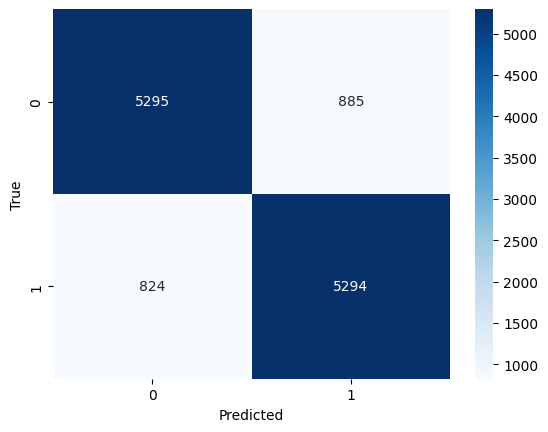

In [114]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred))

Podemos observar que tanto el resultado obtenido está balanceado.

### Gráficos de las métricas en función de los ciclos (epochs)

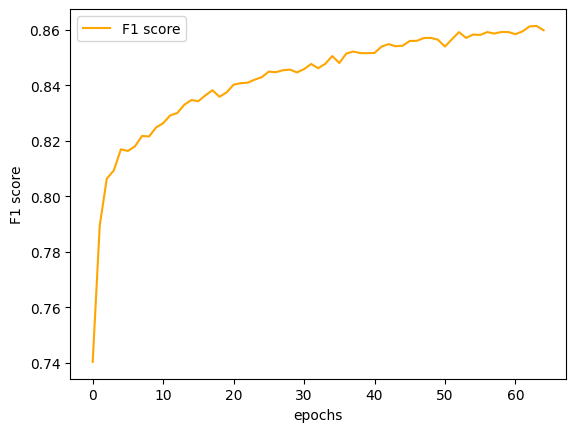

In [115]:
epochs = range(65)

plt.plot(epochs, history.history['get_f1'], color='orange', label='F1 score')
plt.xlabel("epochs")
plt.ylabel("F1 score")
plt.legend()

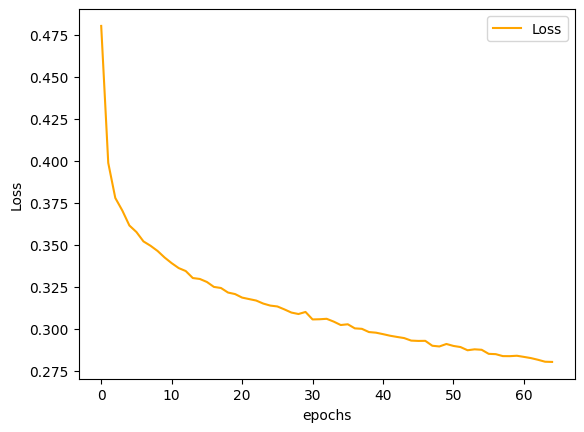

In [116]:
epochs = range(65)

plt.plot(epochs, history.history['loss'], color='orange', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

Podemos observar en los gráficos, que 65 epochs e un buen numero, ya que reduce loss correctamente y aumenta f1 score pero sin overfitting. 

## Exportado de Predicciones

Realizamos la descarga del modelo y la predicción realizada para subir a la competencia.

In [117]:
import joblib
joblib.dump(best_model, 'modelo_red_neuronal_early_stop.pkl')
loaded_model = joblib.load('modelo_red_neuronal_early_stop.pkl')
predicciones = loaded_model.predict(df_hotel_test)

830/830 [==============================] - 1s 1ms/step


In [118]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': np.ravel(predicciones)})
df_sub.to_csv('prediccion_redn_early_stop.csv', index=False)